# RNN for time-series - The nn.RNN module

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.column_data import *
from fastai.text import *

## Generate some data

In [3]:
N  = 1000000 # Number of samples
b, c, tau = 0.1, 0.2, 17
y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
     1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]
for n in range(17,N+99):
    y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
x = np.array(y[100:])
n = np.array(list(range(len(x)))) # n is just for testing purposes

In [4]:
path = 'data/'

## Create sequences

In [5]:
seq_len = 10
xs = x.reshape(-1,seq_len)
ns = n.reshape(-1,seq_len)
xs.shape, ns.shape

((100000, 10), (100000, 10))

In [6]:
ys, yn = xs[1:,0].reshape(-1,1), ns[1:,0].reshape(-1,1)
xs, ns = xs[:-1,:], ns[:-1,:]

In [7]:
# Last 30% of data for validation
val_idx = np.arange(len(xs)//(1/0.7), len(xs)).astype(int);

## Define and train the model

In [8]:
# fastai.text
class RNN_Learner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return F.cross_entropy
    def fit(self, *args, **kwargs): return super().fit(*args, **kwargs, seq_first=False)

    def save_encoder(self, name): save_model(self.model[0], self.get_model_path(name))
    def load_encoder(self, name): load_model(self.model[0], self.get_model_path(name))

In [9]:
# Based on Lesson 6 CharRnn model (lesson6-rnn.ipynb)
class TSRnn(nn.Module):
    def __init__(self, in_sz, h_sz, out_sz):
        super().__init__()
        self.in_sz = in_sz
        self.h_sz = h_sz
        self.rnn = nn.RNN(in_sz, h_sz)
        self.lin_out = nn.Linear(h_sz, out_sz)
    
    def forward(self, *xs):
        bs = xs[0].size()[0]
        h = torch.zeros((1, bs, self.h_sz), requires_grad=True).cuda()
        x = torch.stack(xs).view(-1, bs, self.in_sz)
        outp, h = self.rnn(x, h)
        return self.lin_out(outp[-1])

In [10]:
md = ColumnarModelData.from_arrays(path, val_idx, xs.astype(float), ys.astype(float), bs=100)

In [11]:
# https://github.com/fastai/fastai/blob/master/courses/dl2/translate.ipynb
m = RNN_Learner(md, SingleModel(to_gpu(TSRnn(1,10,1))))
m.crit = nn.L1Loss()

In [12]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|███████▎  | 513/700 [00:01<00:00, 389.94it/s, loss=0.156] 


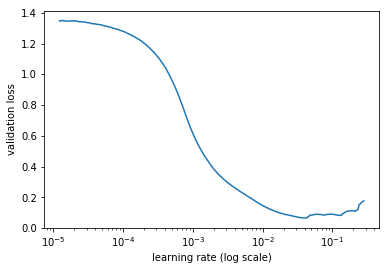

In [13]:
m.sched.plot()

In [14]:
lr = 1e-2
m.fit(lr, 1, cycle_len=20, use_clr_beta=(20,10, 0.95, 0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.027708   0.025245  
    1      0.007789   0.006821                                  
    2      0.007754   0.005877                                  
    3      0.008233   0.015318                                  
    4      0.007203   0.004465                                  
    5      0.010736   0.006912                                  
    6      0.006846   0.012825                                  
    7      0.005394   0.005123                                  
    8      0.009075   0.022297                                  
    9      0.008877   0.011374                                  
    10     0.005092   0.004911                                  
    11     0.005109   0.011318                                  
    12     0.006382   0.009401                                  
    13     0.00497    0.00477                                   
    14     0.003601   0.002251                            

[0.0012909268673198919]

## Multi-step predictions

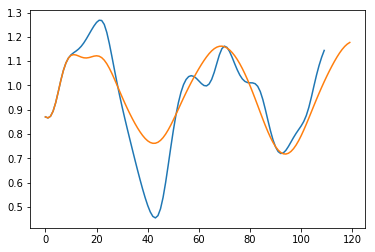

In [15]:
# Generate test data
N  = 100 + seq_len # Number of samples
b, c, tau = 0.1, 0.2, 17
y = [0.9697, 0.9699, 0.9794, 1.0003, 1.0319, 1.0703, 1.1076, 1.1352, 1.1485,
     1.1482, 1.1383, 1.1234, 1.1072, 1.0928, 1.0820, 1.0756, 1.0739, 1.0759]
y = list(np.random.permutation(y))
for n in range(17,N+99):
    y.append(y[n] - b*y[n] + c*y[n-tau]/(1+y[n-tau]**10))
x = np.array(y[100:])

in_test = [T(o) for o in x[:seq_len]]

out_save = []
while len(out_save) < N:
    out = m.model(*in_test)
    in_test = [*in_test, out[0]][1:]
    out_save.append(out.item())

plt.plot(x)
plt.plot([*x[:seq_len], *out_save])